In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SPIKE_PROB = 0.8
TRAINING_BIAS = 2
POTENTIAL_DECAY = 0.8
CURRENT_DECAY = 0.8

In [3]:

# Generates a list representing the input current voltage across total duration in milliseconds where the current begins and runs for the set duration
def Input_Current(total_duration, voltage_array, voltage_start_times, voltage_duration):
    current_input_array = np.zeros(total_duration)
    if not isinstance(voltage_array, list):
        voltage_array=[voltage_array]
    if not isinstance(voltage_start_times, list):
        voltage_start_times=[voltage_start_times]
    if len(voltage_array)!=len(voltage_start_times):
        raise Exception("Unequal lengths for voltage and start times")
    for i in range(len(voltage_array)):
        voltage=voltage_array[i]
        start_time=voltage_start_times[i]
        for j in range(voltage_duration):
            current_input_array[start_time+j]=voltage
    return current_input_array

# Checks to determine if the current voltage has surpassed the voltage threshold
def Spike_Occurred(current_voltage,voltage_threshold):
    if(current_voltage>voltage_threshold):
        return True
    else:
        return False

In [4]:
# # The Neuron Class manages all the parameters and models that are used for testing.  
# # The class requires the models are first initialized by giving the model parameters before running
# # Then the proper model's membrane potential function can be called for a given input current
# # The returned voltage and spiking behavior across the duration of the current will be returned

# class Neuron:
#     def __init__(self):
#         self.LIF_initialilzed = False

#     def Initialize_LIF(self,neuron_resting_voltage,neuron_firing_threshold,C_m, R_m):
#         self.C_m = C_m
#         self.R_m = R_m
#         self.resting_voltage=neuron_resting_voltage
#         self.voltage_threshold=neuron_firing_threshold
#         self.LIF_initialized = True
        
#     def LIF_Neuron_Voltage_Change(self,I, V_m):
#         if self.LIF_initialized:
#             voltage_change = ((I*self.R_m) - V_m)/(self.R_m*self.C_m)
#             return voltage_change
#         else:
#             raise Exception('LIF was not initialized')
        
#     def LIF_Membrane_Potential(self,input_current):
#         membrane_potential_array = []
#         spike_occurrence_array = []
    
#         current_voltage = self.resting_voltage
    
#         for t in range(len(input_current)):
#             if Spike_Occurred(current_voltage,self.voltage_threshold):
#                 current_voltage = self.resting_voltage
#                 spike_occurrence_array.append(1)
#             else:
#                 voltage_change = self.LIF_Neuron_Voltage_Change(input_current[t],current_voltage)
#                 current_voltage=current_voltage+voltage_change
#                 spike_occurrence_array.append(0)
#             membrane_potential_array.append(current_voltage)
        
#         return membrane_potential_array,spike_occurrence_array
        
    

In [5]:
# The Neuron Class manages all the parameters and models that are used for testing.  
# The class requires the models are first initialized by giving the model parameters before running
# Then the proper model's membrane potential function can be called for a given input current
# The returned voltage and spiking behavior across the duration of the current will be returned

POTENTIAL_DECAY = 0.8
CURRENT_DECAY = 0.8
class Neuron:
    def __init__(self):
        self.LIF_initialilzed = False

    def Initialize_LIF(self,neuron_resting_voltage,neuron_firing_threshold,C_m, R_m):
        self.C_m = C_m
        self.R_m = R_m
        self.resting_voltage=neuron_resting_voltage
        self.voltage_threshold=neuron_firing_threshold
        self.LIF_initialized = True
        
    def LIF_Neuron_Voltage_Current_Change(self,t,I, V_m, spike_trains, trained_weights):
        if self.LIF_initialized:
            I[t] = CURRENT_DECAY*I[t-1] + np.sum(spike_trains[:,t]*trained_weights)
            if V_m[t-1] < self.voltage_threshold:
                V_m[t] = POTENTIAL_DECAY*V_m[t-1] + I[t]
            else:
                V_m[t] = self.resting_voltage
            return I, V_m
        else:
            raise Exception('LIF was not initialized')
        
    def LIF_Membrane_Potential(self,input_current, spike_trains, trained_weights):

        spike_occurrence_array = [0]
    
        current_voltage = self.resting_voltage
        V_m = np.zeros(len(input_current))
        V_m[0] = current_voltage
        
        for t in range(1,len(input_current)):
            if Spike_Occurred(current_voltage,self.voltage_threshold):
                current_voltage = self.resting_voltage
                spike_occurrence_array.append(1)
            else:
                V_m, I = self.LIF_Neuron_Voltage_Current_Change(t,input_current, \
                                       V_m,spike_trains, trained_weights)
                current_voltage = V_m[t]
                spike_occurrence_array.append(0)
        
        return input_current, V_m,spike_occurrence_array
        
    

In [6]:
class Data:
    def __init__(self, size, num_neurons, gate):
        self.size = size
        self.num_neurons = num_neurons
        self.gate = gate
#         return [self.encode(), self.teacher_neuron()]
        
    """
    Generate spike trains
    """
    def encode(self):
        #Need to change this to someother distribution
        spike_train = []
        for i in range(self.num_neurons):
            spike_train.append(np.random.choice([0,1], self.size,p=[1-SPIKE_PROB,SPIKE_PROB]))
        self.spike_train = spike_train
        return np.asarray(self.spike_train)
    
    def teacher_neuron(self):
        gate = self.gate
        if gate == "AND":
            self.teacher = np.logical_and(self.spike_train[0],self.spike_train[1])
        if gate == "OR":
            self.teacher = np.logical_or(self.spike_train[0],self.spike_train[1])
        if gate == "XOR":
            self.teacher = np.logical_xor(self.spike_train[0],self.spike_train[1])
        return self.teacher.astype(int)
    
    def generate_data(self):
        return self.encode(), self.teacher_neuron()
    
#     def decode()

class Train:
    def __init__(self,spike_train,teacher):
        self.bias = TRAINING_BIAS
        self.teacher = teacher
        self.spike_trains = spike_train
        self.len_spike_train = len(spike_train)
        self.weigths = np.zeros(self.len_spike_train)
    
    def get_a_corr(self,spike_train, teacher):
        #This needs to be changed
        return np.logical_and(spike_train,teacher).astype(int)
        
    
    def fit(self):
        for i,spike_train in enumerate(self.spike_trains):
            for j,(n,t) in enumerate(zip(spike_train,teacher)):
                a_corr = self.get_a_corr(spike_train, teacher)
                dw = a_corr[j]*n*t
                self.weigths[i] = self.weigths[i] + dw 
        return self.weigths
        
        

In [7]:
# This class takes lists of input currents, membrane potentials, and spikes and plots them.

class Spike_Plotter:
    def __init__(self):
        pass
        
    def Plot_Spiking_Behavior(self,input_current,membrane_potential,spikes,title):
        fig,axes = plt.subplots(3,1,sharex=True)
        t = np.arange(len(input_current))
        self.Plot_Current(axes[0],t,input_current)
        self.Plot_Membrane_Potential(axes[1],t,membrane_potential)
        self.Plot_Spikes(axes[2],t,spikes)
        axes[0].set_title(title)
        plt.show()
    
    def Plot_Current(self,ax,t,input_current):
        ax.plot(t,input_current)
        ax.set_ylabel("I (mV)")
    
    def Plot_Membrane_Potential(self,ax,t,membrane_potential):
        ax.plot(t,membrane_potential)
        ax.set_ylabel("V (mV)")
    
    def Plot_Spikes(self,ax,t,spikes):
        ax.plot(t,spikes)
        ax.set_ylabel("Spikes")
        ax.set_xlabel("Time (ms)")




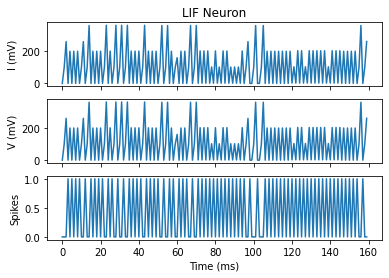

In [14]:
#LIP Parameters
neuron_resting_voltage=0
neuron_firing_threshold=100
C_m=2
R_m=1.5


# Input Current
total_duration=160
start_time=[20,70,120]
duration=25 # Duration of current

neuron=Neuron()
neuron.Initialize_LIF(neuron_resting_voltage,neuron_firing_threshold,C_m,R_m)
plotter = Spike_Plotter()

voltage=[0.6,1.2,2]


input_current=Input_Current(total_duration,voltage,start_time,duration)
len_current = len(input_current)

data = Data(len_current,2,"AND")
spike_train, teacher = data.generate_data()
# teacher = data.teacher_neuron()

train = Train(spike_train,teacher)
trained_weights = train.fit()




input_current, membrane_potential,spike_occurrence = neuron.LIF_Membrane_Potential(input_current,spike_train,trained_weights)
plotter.Plot_Spiking_Behavior(input_current,membrane_potential,spike_occurrence,"LIF Neuron")




In [9]:
len(membrane_potential)

160

In [10]:
# #Testingbed
# data = Data(10,2,"AND")
# spike_train, teacher = data.generate_data()
# # teacher = data.teacher_neuron()

# train = Train(spike_train,teacher)
# weights = train.fit()
# print(spike_train[0])
# print(spike_train[1])
# print(teacher)
# print(weights)
